In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg
import copy

# Display Matplotlib figures inline
%matplotlib inline

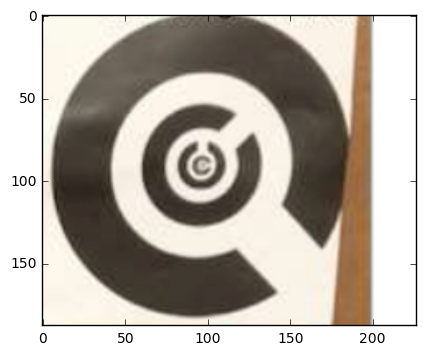

In [16]:
# Load the data. 
incorrect_image = cv2.imread("RMRC-test - Copy.png")
image = cv2.cvtColor(incorrect_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

# Convert RGB Image to greyscale
img = copy.copy(image)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

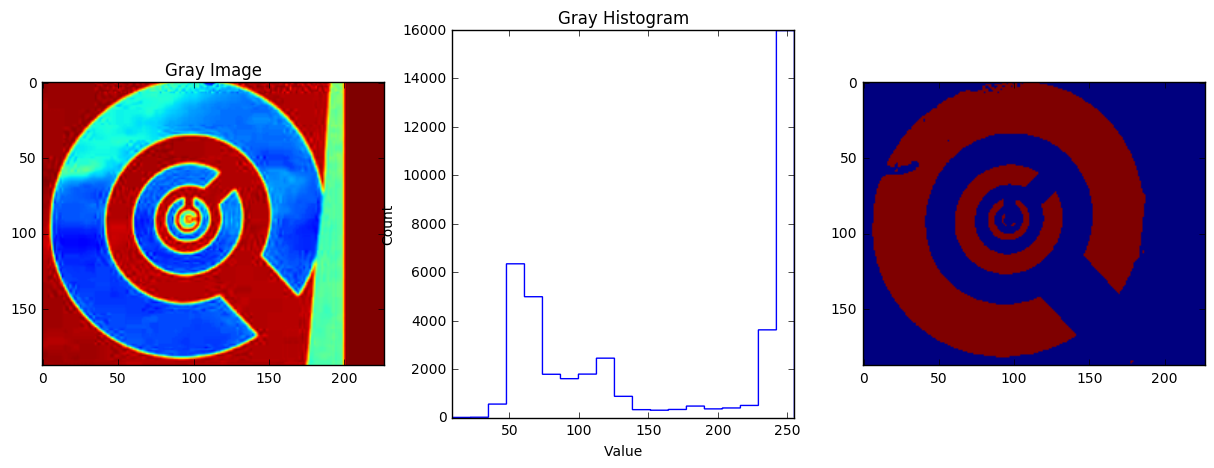

In [30]:
# Create a zero mask, and filter out the shapes by colour
THRESHOLD = 110
gray_mask = np.zeros_like(gray)
gray_mask[gray<THRESHOLD] = 250

# Some graphs to show that this works and why
gray_flat = gray[np.isfinite(gray)]
black, white = np.min(gray_flat), np.max(gray_flat)

plt.figure('Gray Image and Histogram', figsize=(15, 5))
        
plt.subplot(1, 3, 1)
plt.imshow(gray)
plt.title('Gray Image')

plt.subplot(1,3,2)
plt.hist(gray_flat, bins=np.linspace(black,white, 20), histtype='step')
plt.xlim(black, white)
plt.title('Gray Histogram')
plt.xlabel('Value')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.imshow(gray_mask)
plt.show()

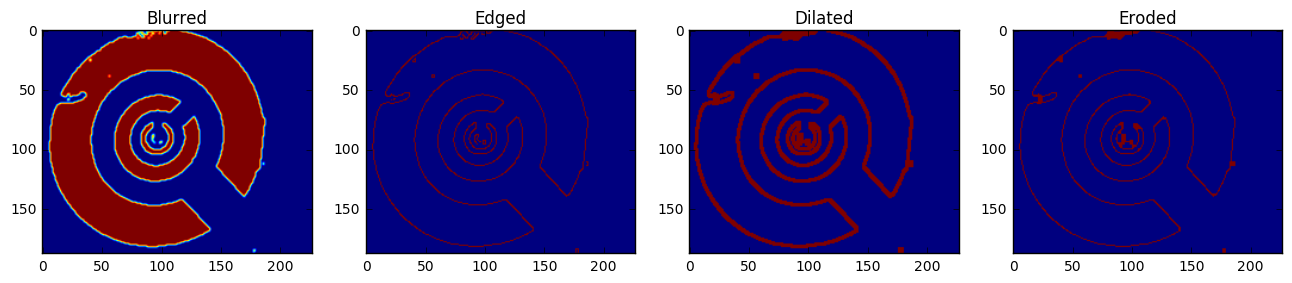

In [31]:
# Define the constants we'll be using below
MAX_THRESH = 200
MIN_THRESH = 60
BLUR = 3
DILATE = 1
ERODE = 1

# Blurring is an important technique in feature extraction.
# In this image ("test1.jpg"), you might notice that a small bit of noise in the yellow triangle was removed

#blurred = cv2.blur(copy.copy(gray_mask), (BLUR,BLUR))
#blurred = cv2.medianBlur(copy.copy(gray_mask), BLUR)
#blurred = cv2.GaussianBlur(copy.copy(gray_mask), (BLUR, BLUR), 0)
blurred = cv2.GaussianBlur(copy.copy(gray_mask), (BLUR, BLUR), 0)
# Perform Canny edge detection

edged = cv2.Canny(blurred, MIN_THRESH, MAX_THRESH)

# Perform a dilation + erosion to close gaps in between object edges
edged_dilated = cv2.dilate(edged, None, iterations=DILATE)
edged_eroded = cv2.erode(edged_dilated, None, iterations=ERODE)

# You can observe the effect of each step below
plt.figure(figsize=[16,4])
plt.subplot(1,4,1)
plt.title("Blurred")
plt.imshow(blurred)
plt.subplot(1,4,2)
plt.title("Edged")
plt.imshow(edged)
plt.subplot(1,4,3)
plt.title("Dilated")
plt.imshow(edged_dilated)
plt.subplot(1,4,4)
plt.title("Eroded")

plt.imshow(edged_eroded)

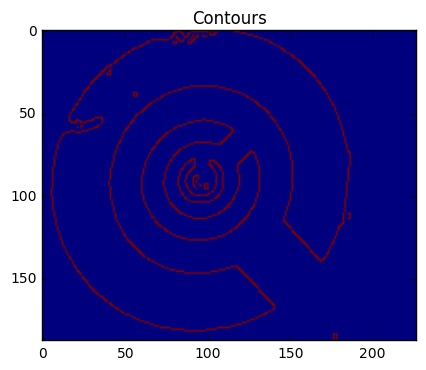

In [32]:
CNT_MODE = cv2.RETR_EXTERNAL

# Extract the contours
edged_img, cnts, hierarchy = cv2.findContours(edged.copy(), CNT_MODE, cv2.CHAIN_APPROX_SIMPLE)
plt.figure()
plt.title("Contours")
plt.imshow(edged_img)
plt.show()len(cnts)

In [33]:
len(cnts)

13

In [34]:
def detect(cnt):
    # Find the perimeter
    peri = cv2.arcLength(cnt, True)
    
    # Approximate the shape. 
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
    return approx

In [40]:
shape_list = []
for i,c in enumerate(cnts):
    shape_object = {}
        
    # Ignore shapes that are too small. 
    # None of the contours in the test image should be affected by this though
    if cv2.contourArea(c) < 150:
        print ("Too small")
        continue
    
    # Approximate the shape of the contour
    approx = detect(c)

    # Ignore objects that are impossibly big
    peri = cv2.arcLength(c, True)
    if peri>5000:
        print ("Perimeter too big: ", peri)
        continue
        
    # Find Shape Centre. Note again that the `approx` variable is a numpy array
    # So numpy arrays can be easily used for contour variables
    centre = np.mean(approx, axis=0)
    shape_object['centre']=centre
    
    # Determine the shape of the object by the number of approx points.
    if len(approx)==3:
        shape='Triangle'
        
    elif len(approx)==4:
        vect1 = approx[0]-approx[1]
        vect2 = approx[1]-approx[2]
        # Determine the length of the points. 
        len_side1 = linalg.norm(vect1)
        len_side2 = linalg.norm(vect2)
        
        aspect = float(len_side1)/len_side2

        if aspect < 1:
            aspect = 1/aspect
        if aspect>1.3:
            shape = 'Rectangle'
        else:
            shape = 'Square'
                
    elif len(approx) == 5:
        shape = 'Pentagon'

    else:
        shape = 'Circle'
        
    shape_object['shape']=shape
    shape_object['approx']=approx
    shape_object['centre']=centre[0][0], centre[0][1]
    
    shape_list.append(shape_object)


Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small
Too small


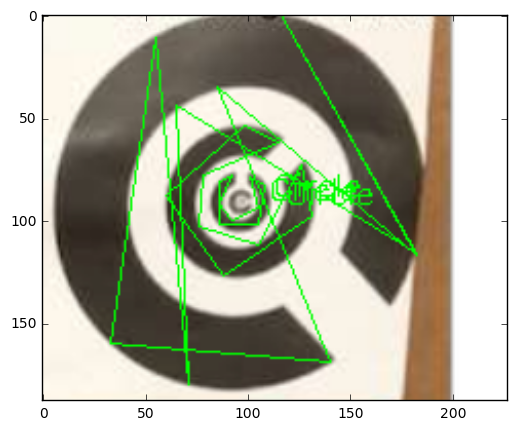

In [41]:
# Get a copy of our original image
show_img = copy.copy(img)

# For each shape, draw the contours, and put the text indicating the shape of the object
for shape in shape_list:
    cx, cy = shape['centre']
    cv2.drawContours(show_img, [shape['approx']], -1, (0,255,0), 1)
    cv2.putText(show_img, shape['shape'], (int(cx)+15,int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.figure(figsize=[6,6])
plt.imshow(show_img)